# RNN - custom dataset (amazon reviews), tokenizer & pretrained word2vec embeddings


### Importing the libraries

In [1]:
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import json
import gensim.downloader as api 
import numpy as np

## Data Preprocessing

### Loading the dataset

In [2]:
# Load the dataset
input_file_path = "input/All_Beauty.jsonl.gz"
data = []

with open(input_file_path, 'r') as fp:
    for line in fp:
        data.append(json.loads(line.strip()))
        
# Convert to a DataFrame
df = pd.DataFrame(data)
print(df.head())  # Display first few rows

   rating                                      title  \
0     5.0  Such a lovely scent but not overpowering.   
1     4.0     Works great but smells a little weird.   
2     5.0                                       Yes!   
3     1.0                          Synthetic feeling   
4     5.0                                         A+   

                                                text images        asin  \
0  This spray is really nice. It smells really go...     []  B00YQ6X8EO   
1  This product does what I need it to do, I just...     []  B081TJ8YS3   
2                          Smells good, feels great!     []  B07PNNCSP9   
3                                     Felt synthetic     []  B09JS339BZ   
4                                            Love it     []  B08BZ63GMJ   

  parent_asin                       user_id      timestamp  helpful_vote  \
0  B00YQ6X8EO  AGKHLEW2SOWHNMFQIJGBECAF7INQ  1588687728923             0   
1  B081TJ8YS3  AGKHLEW2SOWHNMFQIJGBECAF7INQ  1588615855070  

### Preprocessing the data

In [3]:
# Convert ratings to binary sentiment
df["sentiment"] = df["rating"].apply(lambda x: 1 if x >= 4 else (0 if x <= 2 else None))

# Drop neutral reviews
df = df.dropna(subset=["sentiment"])
df = df[["text", "sentiment"]]  # Keep relevant columns

# Check class distribution
print(df["sentiment"].value_counts())

1.0    500107
0.0    145114
Name: sentiment, dtype: int64


### Preprocessing the review text

In [4]:
# Hyperparameters
max_features = 10000  # Max number of words
max_len = 300  # Max sequence length

df.rename(columns={'text': 'reviewText'}, inplace=True)
# Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, oov_token="<OOV>")
# creates word_index mapping words to unique integers based on word frequency
tokenizer.fit_on_texts(df["reviewText"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["reviewText"])

# Pad sequences to ensure consistent input size
x = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)
y = df["sentiment"].values


### Splitting the data into training and test sets

In [5]:

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Loading Pre-trained Word2Vec (Google News)

In [6]:
# Load pre-trained Word2Vec model (Google News, 300 dimensions)
word2vec = api.load("word2vec-google-news-300")

# Get word index from the tokenizer
word_index = tokenizer.word_index
print("Word index sample:", list(word_index.items())[:10])

# Create embedding matrix
embedding_dim = 300  # Google News Word2Vec uses 300-dimensional vectors
embedding_matrix = np.zeros((max_features, embedding_dim))

# Add random vectors for OOV token (index 1)
embedding_matrix[1] = np.random.uniform(-0.25, 0.25, embedding_dim)  # Random embedding for OOV token

# Assign word embeddings starting from index 2
for word, i in word_index.items():
    if i < max_features and i != 1:  # Skip the OOV token at index 1
        if word in word2vec:
            embedding_matrix[i] = word2vec[word]
        else:
            embedding_matrix[i] = np.random.uniform(-0.25, 0.25, embedding_dim)  # Random vector if no embedding
            
print("Embedding matrix shape:", embedding_matrix.shape)

Word index sample: [('<OOV>', 1), ('the', 2), ('i', 3), ('and', 4), ('it', 5), ('a', 6), ('to', 7), ('this', 8), ('my', 9), ('is', 10)]
Embedding matrix shape: (10000, 300)


## Building the RNN

### Initialising the RNN

In [7]:
model = tf.keras.models.Sequential()

### Embedding layer

In [8]:
# Embedding layer (non-trainable) to represent words as vectors that uses embedding_matrix
model.add(tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))

### Hidden layers

In [9]:
# Recurrent layer (RNN)
model.add(tf.keras.layers.SimpleRNN(128, dropout=0.2, return_sequences=True))
# normalization hidden layer to speed up convergence / training
model.add(tf.keras.layers.BatchNormalization())
# stacking another RNN layer to capture deeper sequential data
model.add(tf.keras.layers.SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
# regularization layer to prevent overfitting
model.add(tf.keras.layers.Dropout(0.5))

### Output layer

In [10]:
# Output layer (binary classification)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

## Training the RNN

### Compiling the RNN

In [11]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

### Training the RNN on the Training set and evaluating it on the Test set

In [12]:
history = model.fit(x_train, y_train, epochs=6, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/6
16131/16131 [==============================] - 30361s 2s/step - loss: 0.3629 - accuracy: 0.8391 - val_loss: 0.3022 - val_accuracy: 0.8649
Epoch 2/6
16131/16131 [==============================] - 7280s 451ms/step - loss: 0.3517 - accuracy: 0.8478 - val_loss: 0.6899 - val_accuracy: 0.6477
Epoch 3/6
16131/16131 [==============================] - 15621s 968ms/step - loss: 0.3644 - accuracy: 0.8422 - val_loss: 0.2884 - val_accuracy: 0.8864
Epoch 4/6
16131/16131 [==============================] - 6677s 414ms/step - loss: 0.3781 - accuracy: 0.8320 - val_loss: 0.3137 - val_accuracy: 0.8655
Epoch 5/6
16131/16131 [==============================] - 7105s 440ms/step - loss: 0.3443 - accuracy: 0.8520 - val_loss: 0.4003 - val_accuracy: 0.8259
Epoch 6/6
16131/16131 [==============================] - 7432s 461ms/step - loss: 0.3587 - accuracy: 0.8398 - val_loss: 0.2892 - val_accuracy: 0.8768


## Visualize the model performance

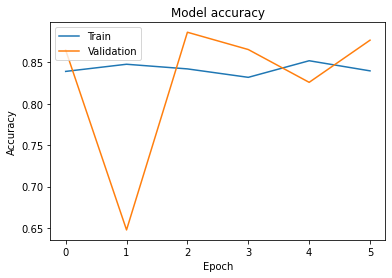

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



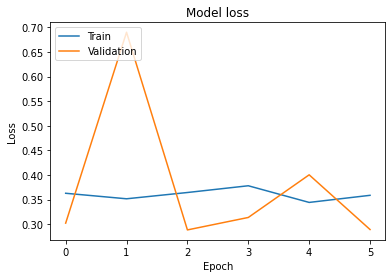

In [18]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Making a single prediction

In [19]:
# Test sentence
test_review_text = "fantastic product , loved it!"

sequence = tokenizer.texts_to_sequences([test_review_text])

# Pad the sequence
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_len)

# Predict sentiment
prediction = model.predict(padded_sequence)

# Interpret result
if prediction[0] > 0.5:
    print("Positive sentiment")
else:
    print("Negative sentiment")

print("Tokenized sequence:", sequence)
print("Padded sequence shape:", padded_sequence.shape)

1/1 [==============================] - 0s 355ms/step
Positive sentiment
Tokenized sequence: [[636, 26, 193, 5]]
Padded sequence shape: (1, 300)


In [20]:
# Test sentence
test_review_text = "worst shampoo , didn't like it at all!"

sequence = tokenizer.texts_to_sequences([test_review_text])

# Pad the sequence
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_len)

# Predict sentiment
prediction = model.predict(padded_sequence)

# Interpret result
if prediction[0] > 0.5:
    print("Positive sentiment")
else:
    print("Negative sentiment")

print("Tokenized sequence:", sequence)
print("Padded sequence shape:", padded_sequence.shape)

1/1 [==============================] - 0s 66ms/step
Negative sentiment
Tokenized sequence: [[805, 278, 158, 32, 5, 43, 36]]
Padded sequence shape: (1, 300)
